In [1]:
import h5py
import torch
cuda = torch.device('cuda')
from kernels import matern, gaussian
from pykeops.torch import LazyTensor
from math import sqrt
import matplotlib.pyplot as plt
from tqdm import tqdm
#Paranoia
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
__useTeX__ = True
if __useTeX__:
    plt.rcParams.update({
        "text.usetex": True,
        "mathtext.fontset": "cm",
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })
from _arnoldi import KernelDMD

In [2]:
from importlib import reload
import _arnoldi
reload(_arnoldi)

<module '_arnoldi' from '/home/novelli/KernelDMD/_arnoldi.cpython-38-x86_64-linux-gnu.so'>

In [7]:
chignolin_path = '../data/md_datasets/chignolin-unbiased/CLN025-0-protein-ALL.h5'
f = h5py.File(chignolin_path, 'r')
coords = f['coordinates'][:]
f.close()
n_frames = coords.shape[0]
d = coords.shape[1]*coords.shape[2]
coords = (coords.reshape(n_frames, d)[::2500,:]).astype('float32')
coords_gpu = torch.tensor(coords, device=cuda)
l = float(torch.nn.functional.pdist(coords_gpu).cpu().numpy().mean())

In [8]:
K = gaussian(coords_gpu, l=l)
cols = []
for i in range(K.shape[0]):
    _e = torch.zeros(K.shape[0], device=cuda)
    _e[i] = 1
    cols.append(K@_e)
K = torch.stack(cols).cpu().numpy()

In [10]:
import numpy as np
np.save("K_mat",K)

In [6]:
h = _arnoldi.KernelDMD(K, K.dtype)

1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0


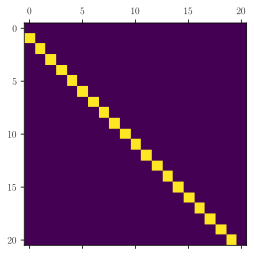

In [10]:
plt.matshow(h)


In [250]:
def KernelDMD(X, kernel, **kernel_args):
    K = kernel(X, **kernel_args)
    q0 = torch.zeros((K.shape[0] + 1), device=cuda)
    q0[0] = 1
    q =  [LazyTensor(q0)] +  [LazyTensor(torch.zeros((K.shape[0]), device=cuda)) for _ in range(K.shape[0]) ]
    # It should be K[0,0]**-0.5, but is 1 for all implemented kernels
    #q[0][0] = 1
    shift_mat = LazyTensor(torch.diag(torch.ones(K.shape[0] - 1),-1), axis=0)
    h = torch.zeros(K.shape, device=cuda)
    print(q[0].shape)
    for i in tqdm(range(K.shape[0])):
        q[i + 1] = shift_mat.matvecmult(q[i]) #Action of the Koopman Operator
        print(q[i+1].shape)
        for j in range(i):
            pass
            #print((q[j]*K.matvecmult(q[i + 1])).sum().shape)
            #h[j, i] = (q[j]*K.matvecmult(q[i + 1])).sum()
            #q[i + 1] = q[i + 1] - h[j, i]*q[j]
        if i <  K.shape[0]:
            pass
            #h[i + 1,i] = q[i+1].norm2()@torch.tensor([1.0])
            #q[i+1] = q[i+1]/h[i + 1,i]
    return h

In [251]:
h = KernelDMD(coords_gpu, matern,  **{'l': l**2} )

100%|██████████| 210/210 [00:00<00:00, 8801.17it/s]

(1, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1, 211)
(210, 1,

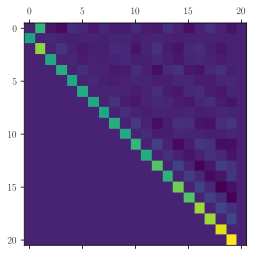

In [ ]:
plt.matshow(h.cpu().numpy())

In [ ]:
L_mat, V = torch.linalg.eig(h)

Text(0, 0.5, '$\\rm{Im}\\, \\lambda$')

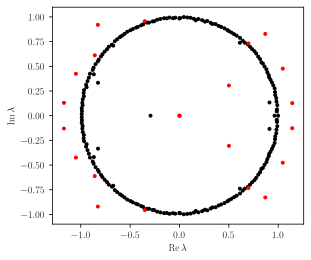

In [ ]:
re_e = L.real.cpu().numpy()
im_e = L.imag.cpu().numpy()
re_e_mat = L_mat.real.cpu().numpy()
im_e_mat = L_mat.imag.cpu().numpy()

figure, axes = plt.subplots()
draw_circle = plt.Circle((0, 0), 1,fill=False, lw =0.5)
axes.set_aspect(1)
axes.add_artist(draw_circle)
axes.plot(re_e, im_e, 'k.')
axes.plot(re_e_mat, im_e_mat, 'r.')
axes.set_xlabel(r'$\rm{Re}\, \lambda$')
axes.set_ylabel(r'$\rm{Im}\, \lambda$')

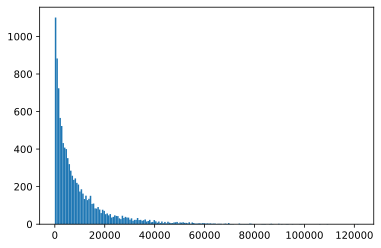

In [ ]:

K = matern(coords_gpu, nu=2.5, l=l)
_e1 = torch.zeros(K.shape[0], device=cuda)
_e1[0] = 1
plt.hist((K@_e1).cpu().numpy(), 200);

In [218]:
a = torch.arange(10, dtype=float) + 2

In [219]:
shift_mat = torch.diag(torch.ones(9,dtype=float),-1)

In [220]:
shift_mat@a

tensor([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.], dtype=torch.float64)

In [209]:
a

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
gaussian_conv = Genred('Exp(-G * SqDist(X,Y)) * B', # F(g,x,y,b) = exp( -g*|x-y|^2 ) * b
                       ['G = Pm(1)',          # First arg  is a parameter,    of dim 1
                        'X = Vi(3)',          # Second arg is indexed by "i", of dim 3
                        'Y = Vj(3)',          # Third arg  is indexed by "j", of dim 3
                        'B = Vj(2)'],         # Fourth arg is indexed by "j", of dim 2
                       reduction_op='Sum',
                       axis=1)                # Summation over "j"


# N.B.: a.shape == [1000, 2]
a = gaussian_conv(gamma, x, y, b)

# By explicitly specifying the backend, you can try to optimize your pipeline:
a = gaussian_conv(gamma, x, y, b, backend='GPU')
a = gaussian_conv(gamma, x, y, b, backend='CPU')

def gaussian(X, l=1):
    #Assuming X = [observations, features]
    l = l**2
    l *=2
    _x = LazyTensor(X[:, None, :])
    _xx = LazyTensor(X[None, :, :])
    D = ((_x - _xx) ** 2).sum(-1)  # Euclidean squared distance
    return (-D/l).exp()